In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

In [37]:
data = pd.read_csv('Cabbage.csv')

In [38]:
#Drop na's.
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)

,date,centre_name,commodity_name,price
0,2001-01-09,DELHI,Cabbage,20
1,2001-01-09,MUMBAI,Cabbage,18
2,2001-01-10,DELHI,Cabbage,12
3,2001-01-13,DELHI,Cabbage,16
4,2001-01-13,MUMBAI,Cabbage,12
...,...,...,...,...
1245,2015-12-09,DELHI,Cabbage,12
1246,2015-12-09,MUMBAI,Cabbage,20
1247,2015-12-10,DELHI,Cabbage,26
1248,2015-12-11,DELHI,Cabbage,11


In [39]:
#calculate average price for each centre for each day 
data_gp = data.sort_values('date').groupby(['centre_name', 'date'], as_index=False)
data_gp = data_gp.agg({'price':['mean']})
data_gp.columns = ['centre_name', 'date', 'price']
data_gp.head()

,centre_name,date,price
0,DELHI,2001-01-09,20
1,DELHI,2001-01-10,12
2,DELHI,2001-01-13,16
3,DELHI,2001-01-14,22
4,DELHI,2001-02-10,12


In [40]:
#centre_1_train_dataset
centre_1_data = data_gp.loc[(data_gp['centre_name']=="DELHI"),["price"]].values
centre_1_data = centre_1_data.astype("float32")

#centre_2_train_dataset
centre_2_data = data_gp.loc[(data_gp['centre_name']=="KOLKATA"),["price"]].values
centre_2_data = centre_2_data.astype("float32")

#centre_2_train_dataset
centre_3_data = data_gp.loc[(data_gp['centre_name']=="MUMBAI"),["price"]].values
centre_3_data = centre_3_data.astype("float32")

print(centre_1_data.size,centre_2_data.size,centre_3_data.size)

628 177 445


In [41]:
#take last year as test dataset
train_centre_1 = centre_1_data[:-365]
test_centre_1 = centre_1_data[-365:]

train_centre_2 = centre_2_data[:-365]
test_centre_2 = centre_2_data[-365:]

train_centre_3 = centre_3_data[:-365]
test_centre_3 = centre_3_data[-365:]

print("train size: {}, test size: {}".format(len(train_centre_1), len(test_centre_1)))

train size: 263, test size: 365


In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#transform the data using minmax scaler
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_3 = MinMaxScaler(feature_range=(0,1))

train_centre_1 = scaler.fit_transform(train_centre_1)
test_centre_1 = scaler.transform(test_centre_1)

# train_centre_2 = scaler_2.fit_transform(train_centre_2)
# test_centre_2 = scaler_2.transform(test_centre_2)

train_centre_3 = scaler_3.fit_transform(train_centre_3)
test_centre_3 = scaler_3.transform(test_centre_3)

In [43]:
#train:

time_step = 30
datax_centre_1=[]
datay_centre_1=[]

for i in range(len(train_centre_1)-time_step-1):
    datax_centre_1.append(train_centre_1[i:(i+time_step),0])
    datay_centre_1.append(train_centre_1[i+time_step,0])
trainx_centre_1=np.array(datax_centre_1)
trainy_centre_1=np.array(datay_centre_1)

datax_centre_2=[]
datay_centre_2=[]

for i in range(len(train_centre_2)-time_step-1):
    datax_centre_2.append(train_centre_2[i:(i+time_step),0])
    datay_centre_2.append(train_centre_2[i+time_step,0])
trainx_centre_2=np.array(datax_centre_2)
trainy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(train_centre_3)-time_step-1):
    datax_centre_3.append(train_centre_3[i:(i+time_step),0])
    datay_centre_3.append(train_centre_3[i+time_step,0])
trainx_centre_3=np.array(datax_centre_3)
trainy_centre_3=np.array(datay_centre_3)

In [44]:
#test:

datax_centre_1=[]
datay_centre_1=[]

for i in range(len(test_centre_1)-time_step-1):
    datax_centre_1.append(test_centre_1[i:(i+time_step),0])
    datay_centre_1.append(test_centre_1[i+time_step,0])
testx_centre_1=np.array(datax_centre_1)
testy_centre_1=np.array(datay_centre_1)


datax_centre_2=[]
datay_centre_2=[]

for i in range(len(test_centre_2)-time_step-1):
    datax_centre_2.append(test_centre_2[i:(i+time_step),0])
    datay_centre_2.append(test_centre_2[i+time_step,0])
testx_centre_2=np.array(datax_centre_2)
testy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(test_centre_3)-time_step-1):
    datax_centre_3.append(test_centre_3[i:(i+time_step),0])
    datay_centre_3.append(test_centre_3[i+time_step,0])
testx_centre_3=np.array(datax_centre_3)
testy_centre_3=np.array(datay_centre_3)

In [45]:
trainx_centre_1=np.reshape(trainx_centre_1, (trainx_centre_1.shape[0],1,trainx_centre_1.shape[1]))
testx_centre_1=np.reshape(testx_centre_1, (testx_centre_1.shape[0],1,testx_centre_1.shape[1]))

# trainx_centre_2=np.reshape(trainx_centre_2, (trainx_centre_2.shape[0],1,trainx_centre_2.shape[1]))
# testx_centre_2=np.reshape(testx_centre_2, (testx_centre_2.shape[0],1,testx_centre_2.shape[1]))

trainx_centre_3=np.reshape(trainx_centre_3, (trainx_centre_3.shape[0],1,trainx_centre_3.shape[1]))
testx_centre_3=np.reshape(testx_centre_3, (testx_centre_3.shape[0],1,testx_centre_3.shape[1]))


In [46]:
model =Sequential()
model.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_1 = model.fit(trainx_centre_1, trainy_centre_1, epochs=100, batch_size=32,    validation_split=0.1, shuffle=False)

Epoch 1/100
7/7 [==============================] - 0s 46ms/step - loss: 0.9128 - val_loss: 1.5573
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8499 - val_loss: 1.4895
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.7990 - val_loss: 1.4323
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.7567 - val_loss: 1.3846
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.7218 - val_loss: 1.3454
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6928 - val_loss: 1.3133
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6687 - val_loss: 1.2871
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6482 - val_loss: 1.2656
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6303 - val_loss: 1.2478
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6144 - val_loss: 1.2330
Epoch 11/100
7/7 [==========

In [47]:
# model_2 =Sequential()
# model_2.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
# model_2.add(Dense(1))
# model_2.compile(loss='mean_squared_error', optimizer='adam')
# history_2 = model.fit(trainx_centre_2, trainy_centre_2, epochs=100, batch_size=32,   validation_split=0.1, shuffle=False)

In [48]:
model_3 =Sequential()
model_3.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
history_3 = model.fit(trainx_centre_3, trainy_centre_3, epochs=100, batch_size=32,  validation_split=0.1, shuffle=False) 

Epoch 1/100
2/2 [==============================] - 0s 29ms/step - loss: 1.0522 - val_loss: 1.0426
Epoch 2/100
2/2 [==============================] - 0s 14ms/step - loss: 0.9498 - val_loss: 0.8654
Epoch 3/100
2/2 [==============================] - 0s 11ms/step - loss: 0.7884 - val_loss: 0.6675
Epoch 4/100
2/2 [==============================] - 0s 13ms/step - loss: 0.6140 - val_loss: 0.4830
Epoch 5/100
2/2 [==============================] - 0s 12ms/step - loss: 0.4547 - val_loss: 0.3290
Epoch 6/100
2/2 [==============================] - 0s 13ms/step - loss: 0.3240 - val_loss: 0.2108
Epoch 7/100
2/2 [==============================] - 0s 13ms/step - loss: 0.2254 - val_loss: 0.1267
Epoch 8/100
2/2 [==============================] - 0s 14ms/step - loss: 0.1567 - val_loss: 0.0715
Epoch 9/100
2/2 [==============================] - 0s 11ms/step - loss: 0.1129 - val_loss: 0.0390
Epoch 10/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0883 - val_loss: 0.0228
Epoch 11/100
2/2 [=

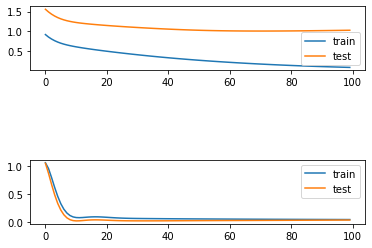

In [49]:
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend();

# plt.subplot(3, 1, 2)
# plt.plot(history_2.history['loss'], label='train')
# plt.plot(history_2.history['val_loss'], label='test')
# plt.legend();

plt.subplot(3, 1, 3)
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend();

In [50]:
trainy_centre_1 = trainy_centre_1.reshape(1,-1)
testy_centre_1 = testy_centre_1.reshape(1,-1)

# trainy_centre_2 = trainy_centre_2.reshape(1,-1)
# testy_centre_2 = testy_centre_2.reshape(1,-1)

trainy_centre_3 = trainy_centre_3.reshape(1,-1)
testy_centre_3 = testy_centre_3.reshape(1,-1)

In [51]:
testPredict_centre_1 = model.predict(testx_centre_1)
testPredict_centre_1 = scaler.inverse_transform(testPredict_centre_1)
testy_centre_1 = scaler.inverse_transform(testy_centre_1)
trainPredict_centre_1 = model.predict(trainx_centre_1)
trainPredict_centre_1 = scaler.inverse_transform(trainx_centre_1)
trainy_centre_1 = scaler.inverse_transform(trainy_centre_1)

# testPredict_centre_2 = model.predict(testx_centre_2)
# trainPredict_centre_2 = model.predict(trainx_centre_2)
# trainPredict_centre_2 = scaler.inverse_transform(trainx_centre_2)
# testPredict_centre_2 = scaler.inverse_transform(testPredict_centre_2)
# testy_centre_2 = scaler.inverse_transform(testy_centre_2)
# trainy_centre_2 = scaler.inverse_transform(trainy_centre_2)

testPredict_centre_3 = model.predict(testx_centre_3)
trainPredict_centre_3 = model.predict(trainx_centre_3)
trainPredict_centre_3 = scaler.inverse_transform(trainx_centre_3)
testPredict_centre_3 = scaler.inverse_transform(testPredict_centre_3)
testy_centre_3 = scaler.inverse_transform(testy_centre_3)
trainy_centre_3 = scaler.inverse_transform(trainy_centre_3)

<Figure size 432x288 with 0 Axes>

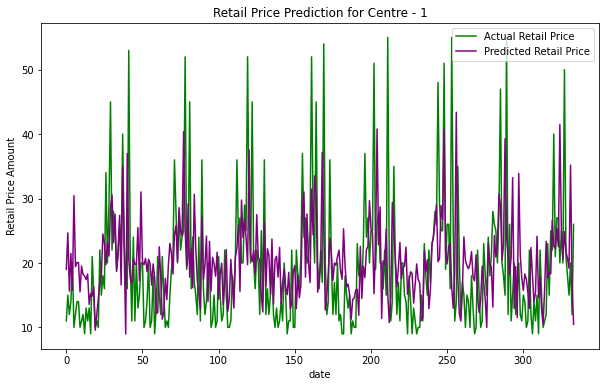

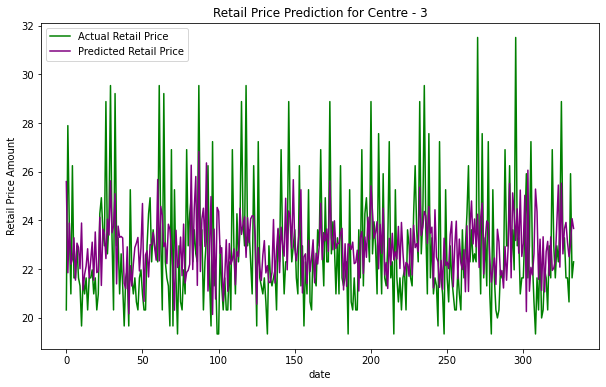

In [52]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(testy_centre_1[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_1 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 1')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(testy_centre_2[0], color='green', label='Actual Retail Price')
# plt.plot(testPredict_centre_2 , color='purple', label='Predicted Retail Price')
# plt.title('Retail Price Prediction for Centre - 2')
# plt.xlabel('date')
# plt.ylabel('Retail Price Amount')
# plt.legend()
# plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_3[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_3 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 3')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

In [53]:
# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE: {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE for centre 1 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_2[0], trainPredict_centre_2[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_2[0], testPredict_centre_2[:,0]))
# print("Train MSE for centre 2 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_3[0], trainPredict_centre_3[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_3[0], testPredict_centre_3[:,0]))
# print("Train MSE for centre 3 model : {}, Test MSE: {}".format(trainscore, testscore))

In [54]:
print(trainy_centre_3[0], trainPredict_centre_3[:,0])

[19.99445  19.6654   25.259262 21.639704 20.652552 21.639704 21.639704
 21.639704 20.323502 24.930212 21.639704 23.61401  22.955908 20.981602
 22.297806 22.955908 28.87882  23.94306  22.955908 29.536922 22.955908
 23.284958 28.87882  23.284958 19.6654   21.639704 21.310654 22.297806
 19.99445  19.6654   24.27211  21.639704 20.652552 21.639704 21.639704
 24.930212 21.639704 26.246416 22.955908 20.981602 24.27211  22.297806
 22.955908 28.87882  22.626856 23.94306  22.955908 22.955908 20.323502] [[21.639704 19.6654   25.259262 ... 21.639704 21.310654 21.639704]
 [19.6654   25.259262 21.639704 ... 21.310654 21.639704 19.99445 ]
 [25.259262 21.639704 20.652552 ... 21.639704 19.99445  19.6654  ]
 ...
 [28.87882  23.94306  22.955908 ... 28.87882  22.626856 23.94306 ]
 [23.94306  22.955908 29.536922 ... 22.626856 23.94306  22.955908]
 [22.955908 29.536922 22.955908 ... 23.94306  22.955908 22.955908]]


# Predicting 90 days of 2015

In [55]:
#use retail price of last 30 days of 2014 to predict next 90 days

#centre-1
testPredict_centre_1 = []

x_data_centre_1 = testx_centre_1[-1] #get transformed retail price values of last 30 days 
x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
yhat = model.predict(x_centre_1)
testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
x_data_centre_1 = np.append(x_data_centre_1,yhat)

for i in range (89):
        x_data_centre_1 = x_data_centre_1[1:]
        x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
        yhat = model.predict(x_centre_1)
        testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
        x_data_centre_1 = np.append(x_data_centre_1,yhat)
        
# #centre-2     
# testPredict_centre_2 = []

# x_data_centre_2 = testx_centre_2[-1] #get transformed retail price values of last 30 days 
# x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
# yhat = model.predict(x_centre_2)
# testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
# x_data_centre_2 = np.append(x_data_centre_2,yhat)

# for i in range (89):
#         x_data_centre_2 = x_data_centre_2[1:]
#         x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
#         yhat = model.predict(x_centre_2)
#         testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
#         x_data_centre_2 = np.append(x_data_centre_2,yhat)
        
#centre-3
testPredict_centre_3 = []

x_data_centre_3 = testx_centre_3[-1] #get transformed retail price values of last 30 days 
x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
yhat = model.predict(x_centre_3)
testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
x_data_centre_3 = np.append(x_data_centre_3,yhat)

for i in range (89):
        x_data_centre_3 = x_data_centre_3[1:]
        x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
        yhat = model.predict(x_centre_3)
        testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
        x_data_centre_3 = np.append(x_data_centre_3,yhat)
        


In [56]:
#Create Dataframe with predicted retail prices
centre_1_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_1_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_1_test_df['centre_name'] = "DELHI"
centre_1_test_df['commodity_name'] = "Cabbage"
centre_1_test_df['predicted_retail_price'] = testPredict_centre_1

# #Create Dataframe with predicted retail prices
# centre_2_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
# centre_2_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
# centre_2_test_df['centre_name'] = "KOLKATA"
# centre_2_test_df['commodity_name'] = "Cabbage"
# centre_2_test_df['predicted_retail_price'] = testPredict_centre_2

#Create Dataframe with predicted retail prices
centre_3_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_3_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_3_test_df['centre_name'] = "MUMBAI"
centre_3_test_df['commodity_name'] = "Cabbage"
centre_3_test_df['predicted_retail_price'] = testPredict_centre_3

test_df = pd.concat([centre_1_test_df, centre_3_test_df],ignore_index=True)
test_df

,date,centre_name,commodity_name,predicted_retail_price
0,2015-01-01,DELHI,Cabbage,10.461397
1,2015-01-02,DELHI,Cabbage,23.893303
2,2015-01-03,DELHI,Cabbage,21.730177
3,2015-01-04,DELHI,Cabbage,17.205416
4,2015-01-05,DELHI,Cabbage,16.494070
...,...,...,...,...
175,2015-03-27,MUMBAI,Cabbage,23.334066
176,2015-03-28,MUMBAI,Cabbage,23.545179
177,2015-03-29,MUMBAI,Cabbage,23.473532
178,2015-03-30,MUMBAI,Cabbage,23.474815


In [57]:
test_df.to_csv('lstm_price_prediction_cabbage.csv',index=False)